# MRMC Holistic Results

In [40]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '../..'))

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn import neighbors
from sklearn import model_selection
from sklearn import manifold
import joblib
from scripts import fit_kde
import json

import matplotlib.pyplot as plt
import seaborn as sns
from models import model_interface, model_loader, model_constants
from data import data_loader
from data.adapters import continuous_adapter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
RECOURSE_METHOD = 'mrmc'
RESULTS_DIR = '../../experiment_results/mrmc/mrmc_holistic'

# Preliminaries -- load everything

In [4]:
DATASET, DATASET_INFO = data_loader.load_data(data_loader.DatasetName('credit_card_default'), split="train")
MODEL = model_loader.load_model(model_constants.ModelType('logistic_regression'), data_loader.DatasetName('credit_card_default'))
ADAPTER = continuous_adapter.StandardizingAdapter(
    label_column = DATASET_INFO.label_column, positive_label=DATASET_INFO.positive_label
).fit(DATASET)

DROP_COLUMNS = ['step_id', 'path_id', 'run_id', 'batch_id']  # columns which are convenient to drop from the path_df

with open(os.path.join(RESULTS_DIR, 'config.json')) as f:
    config_json = json.load(f)

EVAL_SPLIT = config_json['split']

EVAL_DATASET, _ = data_loader.load_data(data_loader.DatasetName('credit_card_default'), split=EVAL_SPLIT)


cluster_df = pd.read_csv(os.path.join(RESULTS_DIR, 'cluster_df.csv'))
config_df = pd.read_csv(os.path.join(RESULTS_DIR, 'experiment_config_df.csv'))
path_df = pd.read_csv(os.path.join(RESULTS_DIR, f'{RECOURSE_METHOD}_paths_df.csv'))
config_df

,batch_id,run_id,run_seed,cluster_seed,confidence_cutoff,max_iterations,noise_ratio,num_clusters,poi_index,rescale_ratio,step_size,volcano_cutoff,volcano_degree,elapsed_recourse_seconds,elapsed_cluster_seconds
0,420,420,7527,1834823,0.7,50,NaN,3,23159,NaN,1,0.5,2,3.093080,0.289569
1,395,395,7527,1834823,0.7,50,NaN,3,13378,NaN,1,0.5,2,2.591012,0.164129
2,593,593,7527,1834823,0.7,50,NaN,3,13527,NaN,1,0.5,2,2.047439,0.160035
3,1004,1004,7527,1834823,0.7,50,NaN,3,18592,NaN,1,0.5,2,2.177958,0.161154
4,76,76,7527,1834823,0.7,50,NaN,3,10537,NaN,1,0.5,2,3.683145,0.159986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,981,981,7527,1834823,0.7,50,NaN,3,849,NaN,1,0.5,2,5.055136,0.356942
1134,456,456,7527,1834823,0.7,50,NaN,3,3641,NaN,1,0.5,2,4.114330,0.259228
1135,128,128,7527,1834823,0.7,50,NaN,3,7310,NaN,1,0.5,2,2.059311,0.489452
1136,91,91,7527,1834823,0.7,50,NaN,3,5718,NaN,1,0.5,2,2.805696,0.377015


## Load or Fit a KDE

In [5]:
KDE_DIRECTORY = '../../saved_models/kde/credit_card_default_kde.joblib'

if os.path.exists(KDE_DIRECTORY):
    KDE = joblib.load(KDE_DIRECTORY)
else:
    KDE = fit_kde.fit_kde('credit_card_default', KDE_DIRECTORY)

# Analyze the results

In [6]:
SPARSITY_EPSILON = 1e-5

def get_poi_cfes(path_df: pd.DataFrame):
    """Isolate the POIs (Points of Interest) and CFEs (Counterfactual Examples) from the full path results.
    
    POIs and CFEs are listed in the order they originally appear in. There is one POI and one CFE
    for every path that appears in the DataFrame."""
    pathscopy = path_df.copy()
    pathscopy['next_step_id'] = 0
    pathscopy.loc[:,'next_step_id'].iloc[0:-1] = pathscopy.loc[:,'step_id'].iloc[1:]
    cfes = pathscopy[pathscopy.step_id >= pathscopy.next_step_id].drop(columns='next_step_id')
    return pathscopy[pathscopy.step_id == 0].drop(columns='next_step_id'), cfes

def get_sparsity(path: pd.DataFrame):
    """Returns the maximum number of features changed in any single iteration
    along the path."""
    if path.shape[0] == 1:
        return np.nan
    path_sparsity = np.zeros(path.shape[0])
    for i in range(1, path.shape[0]):
        path_sparsity[i] = (np.abs(path.iloc[i] - path.iloc[i - 1]) > SPARSITY_EPSILON).sum()
    return np.max(path_sparsity)

def get_path_length(path: pd.DataFrame):
    """Returns the sum of euclidean distances along the path."""
    total = 0
    for i in range(1, path.shape[0]):
        total += np.linalg.norm(path.iloc[i] - path.iloc[i - 1])
    if total == 0:
        return np.nan
    return total

def get_cfe_distance(path: pd.DataFrame):
    """Returns the euclidean distance between the first and last points in the path."""
    if len(path) == 1:
        return np.nan
    return np.linalg.norm(path.iloc[-1] - path.iloc[0])


def analyze_paths(paths: pd.DataFrame, poi_kdes, cfe_kdes, cfe_probs, config_df):
    """Returns a DataFrame containing per-path results.
    
    Each row corresponds to a specific path. Each column is a result metric.
    
    Args:
        paths: The path_df DataFrame to analyze.
        poi_kdes: The KDE scores for the POIs.
        cfe_kdes: The KDE scores for the CFEs.
        config_df: The experiment_config_df for the experiment."""
    columns = ['run_id', 'path_id', 'success', 'proximity', 'path_length',
               'iteration_count', 'poi_density', 'cfe_density', 
               'actual_sparsity']
    col_idx = {}
    for i, col in enumerate(columns):
        col_idx[col] = i

    results = np.zeros((len(poi_kdes), len(columns)))

    i = 0
    for run_id in paths.run_id.unique():
        run_paths = paths[paths.run_id == run_id]
        for path_id in run_paths.path_id.unique():
            path = ADAPTER.transform(run_paths[run_paths.path_id == path_id].drop(columns=DROP_COLUMNS))
            results[i,col_idx['run_id']] = run_id
            results[i,col_idx['path_id']] = path_id

            desired_proba = config_df[config_df.run_id == run_id].confidence_cutoff.iloc[0]
            actual_proba = cfe_probs[i]

            results[i,col_idx['success']] = 1 if actual_proba >= desired_proba else 0
            results[i,col_idx['path_length']] = get_path_length(path)
            results[i,col_idx['iteration_count']] = len(path)
            results[i,col_idx['proximity']] = get_cfe_distance(path)
            results[i,col_idx['poi_density']] = poi_kdes[i]
            results[i,col_idx['cfe_density']] = cfe_kdes[i]
            results[i,col_idx['actual_sparsity']] = get_sparsity(path)
            i += 1

    return pd.DataFrame(data=results, columns=columns)

pois, cfes = get_poi_cfes(path_df)
poi_kdes = KDE.score_samples(ADAPTER.transform(pois.drop(columns=DROP_COLUMNS)))
cfe_kdes = KDE.score_samples(ADAPTER.transform(cfes.drop(columns=DROP_COLUMNS)))
cfe_probs = MODEL.predict_pos_proba(cfes.drop(columns=DROP_COLUMNS)).to_numpy()

results = analyze_paths(path_df, poi_kdes, cfe_kdes, cfe_probs, config_df)
results = results.merge(config_df, how='left', on='run_id').drop(
    columns=['max_iterations', 'noise_ratio',
             'rescale_ratio', 'cluster_seed', 'run_seed',
             'volcano_degree', 'volcano_cutoff'])  # uninteresting columns
results

/tmp/ipykernel_1030/3088119923.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathscopy.loc[:,'next_step_id'].iloc[0:-1] = pathscopy.loc[:,'step_id'].iloc[1:]


,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,num_clusters,poi_index,step_size,elapsed_recourse_seconds,elapsed_cluster_seconds
0,420.0,0.0,1.0,7.965322,8.0,9.0,-17.618665,-1.363219,20.0,420,0.7,3,23159,1,3.093080,0.289569
1,420.0,1.0,1.0,6.995552,7.0,8.0,-17.618665,-29.735818,19.0,420,0.7,3,23159,1,3.093080,0.289569
2,420.0,2.0,1.0,5.962266,6.0,7.0,-17.618665,-0.681659,20.0,420,0.7,3,23159,1,3.093080,0.289569
3,395.0,0.0,1.0,7.975497,8.0,9.0,-1.470329,-1.647185,20.0,395,0.7,3,13378,1,2.591012,0.164129
4,395.0,1.0,1.0,5.998813,6.0,7.0,-1.470329,-43.182930,20.0,395,0.7,3,13378,1,2.591012,0.164129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,91.0,1.0,1.0,5.998462,6.0,7.0,-6.901278,-40.010139,19.0,91,0.7,3,5718,1,2.805696,0.377015
3410,91.0,2.0,1.0,3.982037,4.0,5.0,-6.901278,-0.029524,20.0,91,0.7,3,5718,1,2.805696,0.377015
3411,1032.0,0.0,1.0,6.976456,7.0,8.0,-1.750707,-1.760856,20.0,1032,0.7,3,20696,1,2.844008,0.237390
3412,1032.0,1.0,1.0,5.998231,6.0,7.0,-1.750707,-27.068325,20.0,1032,0.7,3,20696,1,2.844008,0.237390


# Success

StEP always succeeds

In [7]:
DROP_METRICS = ['actual_sparsity', 'run_id', 'batch_id', 'confidence_cutoff', 'num_clusters', 'elapsed_recourse_seconds', 'elapsed_cluster_seconds']

results.groupby('success').count()

,run_id,path_id,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,num_clusters,poi_index,step_size,elapsed_recourse_seconds,elapsed_cluster_seconds
success,,,,,,,,,,,,,,,
1.0,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414


# Iteration count

Some rows have high iteration count. This is because those POIs are outliers.

<AxesSubplot: xlabel='iteration_count', ylabel='Count'>

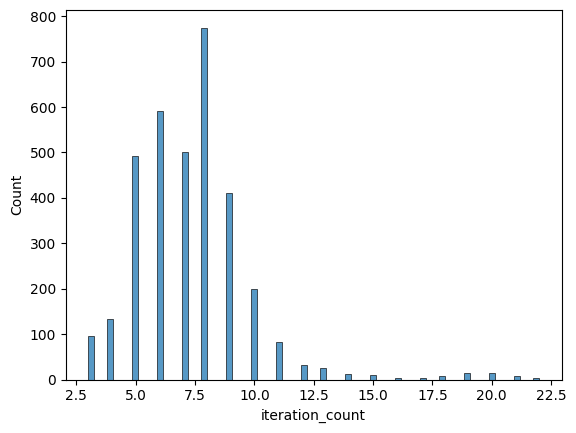

In [8]:
sns.histplot(results, x='iteration_count')

Text(0.5, 1.0, 'Z-Score distribution across full eval set')

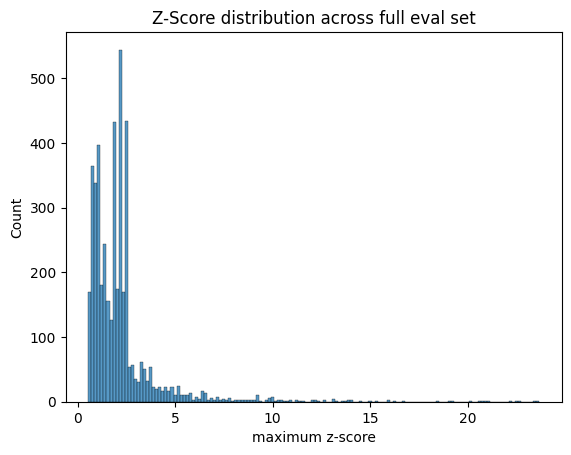

In [9]:
eval_set_zscores = ((EVAL_DATASET - EVAL_DATASET.mean()) / EVAL_DATASET.std()).abs().max(axis=1)
eval_set_zscores.name = 'maximum z-score'
sns.histplot(eval_set_zscores)
plt.title("Z-Score distribution across full eval set")

Text(0.5, 1.0, 'Z-Score distribution across high iteration_count POIs')

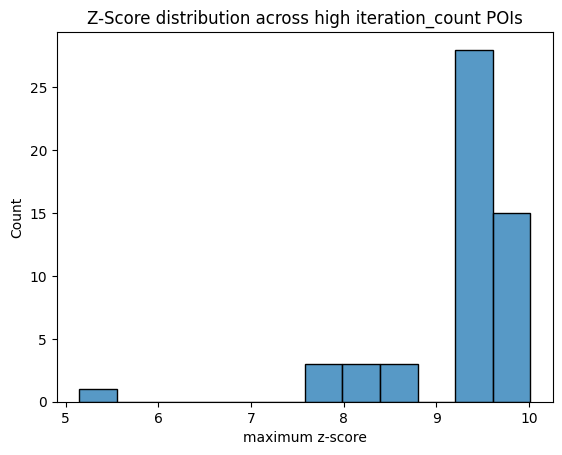

In [10]:
high_iteration_pois = EVAL_DATASET.loc[results[results.iteration_count > 15].poi_index]
high_iteration_zscores = ((high_iteration_pois - EVAL_DATASET.mean()) / EVAL_DATASET.std()).abs().max(axis=1)
high_iteration_zscores.name = 'maximum z-score'
sns.histplot(high_iteration_zscores)
plt.title("Z-Score distribution across high iteration_count POIs")

# Path Length

<AxesSubplot: xlabel='path_length', ylabel='Count'>

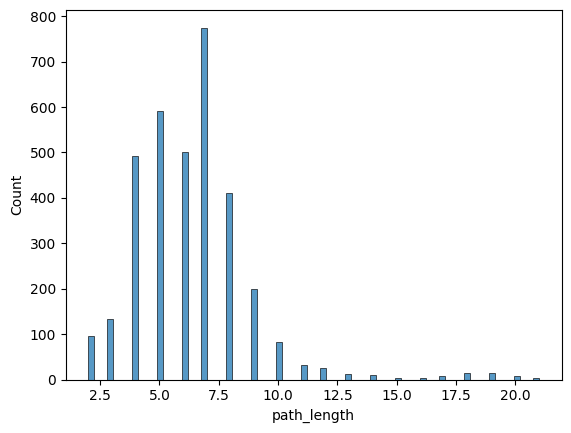

In [11]:
sns.histplot(results, x='path_length')

# Proximity

QUESTION: Why do some points have high proximity?

<AxesSubplot: xlabel='proximity', ylabel='Count'>

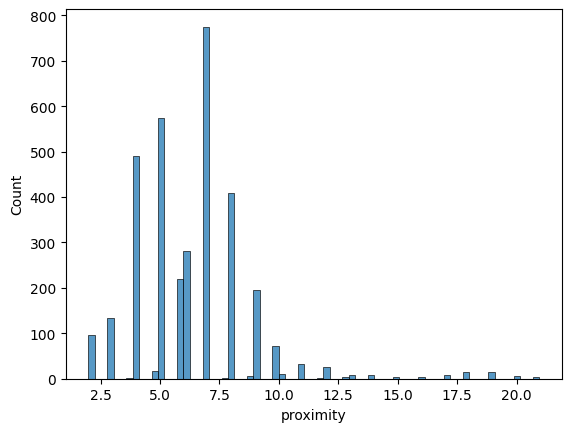

In [12]:
sns.histplot(results, x='proximity')

<AxesSubplot: xlabel='proximity', ylabel='Count'>

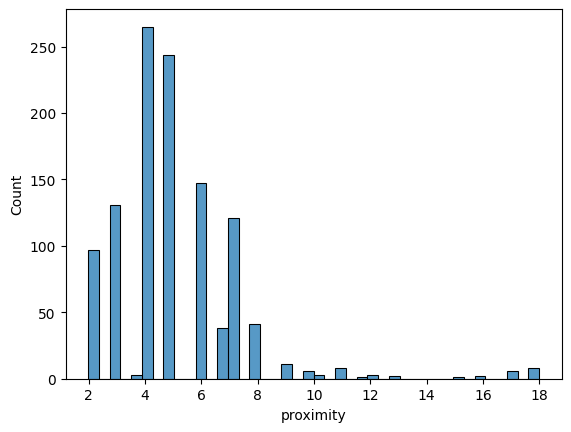

In [39]:
min_prox_results = results.sort_values(['run_id', 'proximity']).iloc[range(0, 3414, 3)]
sns.histplot(min_prox_results, x='proximity')

In [42]:
min_prox_results[min_prox_results.poi_index == 5125]

,run_id,path_id,success,proximity,path_length,iteration_count,poi_density,cfe_density,actual_sparsity,batch_id,confidence_cutoff,num_clusters,poi_index,step_size,elapsed_recourse_seconds,elapsed_cluster_seconds
2141,511.0,2.0,1.0,1.996954,2.0,3.0,-10.056721,-1.571048,20.0,511,0.7,3,5125,1,2.383479,0.568176


In [36]:
path_df[(path_df.run_id == 511) & (path_df.path_id == 2)].iloc[-1] - EVAL_DATASET.loc[5125]

AGE              -4.742171
BILL_AMT1     20206.393463
BILL_AMT2      3021.918610
BILL_AMT3      5636.688952
BILL_AMT4     14211.255348
BILL_AMT5     11666.422366
BILL_AMT6     13967.079397
LIMIT_BAL    148197.138040
PAY_1            -0.848257
PAY_2             0.001947
PAY_3             0.000635
PAY_4             0.005132
PAY_5             0.000549
PAY_6             0.002125
PAY_AMT1      -7027.983558
PAY_AMT2      -3080.664227
PAY_AMT3       5878.527443
PAY_AMT4       2195.379201
PAY_AMT5       5356.501937
PAY_AMT6     -12300.549864
Y                      NaN
batch_id               NaN
path_id                NaN
run_id                 NaN
step_id                NaN
dtype: float64

In [37]:
path_df[(path_df.run_id == 511) & (path_df.path_id == 2)].iloc[-1]

LIMIT_BAL    298197.138040
AGE              35.257829
PAY_1             0.151743
PAY_2             0.001947
PAY_3             0.000635
PAY_4             0.005132
PAY_5             0.000549
PAY_6             0.002125
BILL_AMT1     20191.393463
BILL_AMT2     20692.918610
BILL_AMT3     20153.688952
BILL_AMT4     16081.255348
BILL_AMT5     15161.422366
BILL_AMT6     13967.079397
PAY_AMT1      10658.016442
PAY_AMT2      11436.335773
PAY_AMT3       5878.527443
PAY_AMT4       5690.379201
PAY_AMT5       5356.501937
PAY_AMT6       9453.450136
step_id           2.000000
path_id           2.000000
run_id          511.000000
batch_id        511.000000
Name: 15612, dtype: float64

In [38]:
EVAL_DATASET.loc[5125]

LIMIT_BAL    150000
AGE              40
PAY_1             1
PAY_2             0
PAY_3             0
PAY_4             0
PAY_5             0
PAY_6             0
BILL_AMT1       -15
BILL_AMT2     17671
BILL_AMT3     14517
BILL_AMT4      1870
BILL_AMT5      3495
BILL_AMT6         0
PAY_AMT1      17686
PAY_AMT2      14517
PAY_AMT3          0
PAY_AMT4       3495
PAY_AMT5          0
PAY_AMT6      21754
Y                 0
Name: 5125, dtype: int64

/home/jakeval/umass/research/.venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


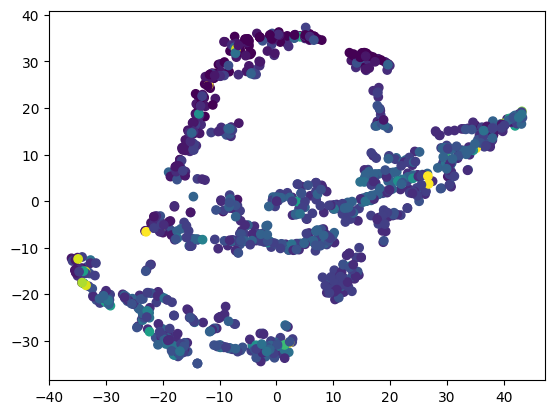

In [41]:
pois = EVAL_DATASET.loc[min_prox_results.poi_index]
tsne = manifold.TSNE(learning_rate='auto')
tsne_data = tsne.fit_transform(pois.drop(columns='Y'))
plt.scatter(x=tsne_data[:,0], y=tsne_data[:,1], c=min_prox_results.proximity)

# Density

(-150.0, 5.0)

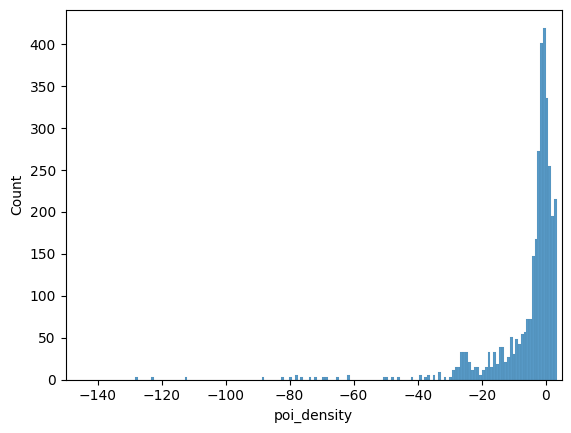

In [13]:
sns.histplot(results, x='poi_density')
plt.xlim(-150, 5)

(-150.0, 5.0)

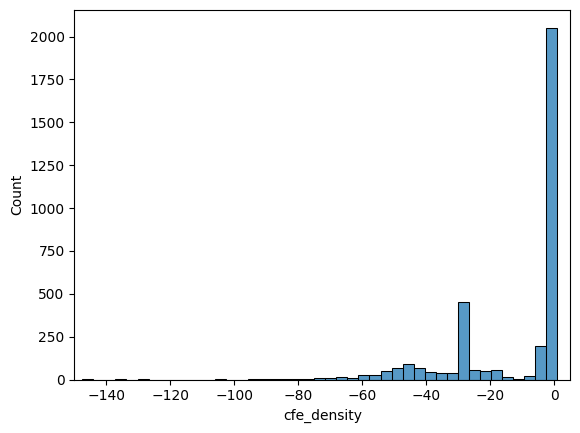

In [14]:
sns.histplot(results, x='cfe_density')
plt.xlim(-150, 5)

In [15]:
results.groupby('path_id').mean()[['cfe_density', 'poi_density', 'proximity']]

,cfe_density,poi_density,proximity
path_id,,,
0.0,-1.789842,-7.64285,7.773360
1.0,-36.269510,-7.64285,5.910424
2.0,-0.963949,-7.64285,5.372617


# Some observations

* Unlike DICE, StEP sometimes recommends paying less
* StEP has broader spread of top-3 columns
* PAY_AMT1, PAY_AMT3, PAY_AMT4, PAY_4, PAY_5, PAY_6

In [16]:
differences = ADAPTER.transform(cfes).drop(columns=['step_id', 'path_id', 'run_id', 'batch_id']).reset_index(drop=True) - ADAPTER.transform(pois.drop(columns = ['step_id', 'path_id', 'run_id', 'batch_id'])).reset_index(drop=True)

(differences.abs()).mean()

LIMIT_BAL    1.589880
AGE          0.758618
PAY_1        1.650408
PAY_2        1.386669
PAY_3        1.200510
PAY_4        1.081319
PAY_5        1.041513
PAY_6        1.016732
BILL_AMT1    1.086214
BILL_AMT2    1.118546
BILL_AMT3    1.104346
BILL_AMT4    1.184455
BILL_AMT5    1.240697
BILL_AMT6    1.208213
PAY_AMT1     0.963259
PAY_AMT2     0.613323
PAY_AMT3     0.871999
PAY_AMT4     0.937347
PAY_AMT5     0.693541
PAY_AMT6     0.614917
dtype: float64

In [19]:
(differences < 0).any()

LIMIT_BAL    True
AGE          True
PAY_1        True
PAY_2        True
PAY_3        True
PAY_4        True
PAY_5        True
PAY_6        True
BILL_AMT1    True
BILL_AMT2    True
BILL_AMT3    True
BILL_AMT4    True
BILL_AMT5    True
BILL_AMT6    True
PAY_AMT1     True
PAY_AMT2     True
PAY_AMT3     True
PAY_AMT4     True
PAY_AMT5     True
PAY_AMT6     True
dtype: bool

In [20]:
df = pd.DataFrame(data = np.sort((-differences.abs().to_numpy()).argpartition(kth=3, axis=1)[:,:3], axis=1), columns=['col1', 'col2', 'col3'])
df['col1'] = differences.columns[df.col1]
df['col2'] = differences.columns[df.col2]
df['col3'] = differences.columns[df.col3]

(-df.groupby(['col1', 'col2', 'col3']).size()).sort_values()[:20]

col1       col2       col3     
PAY_AMT1   PAY_AMT3   PAY_AMT4    -637
PAY_4      PAY_5      PAY_6       -427
LIMIT_BAL  AGE        PAY_1       -163
PAY_5      PAY_AMT1   PAY_AMT4    -157
BILL_AMT4  BILL_AMT5  BILL_AMT6   -149
BILL_AMT1  BILL_AMT4  BILL_AMT5   -129
LIMIT_BAL  PAY_1      PAY_2       -101
PAY_1      PAY_2      PAY_3        -99
PAY_2      PAY_3      PAY_4        -67
PAY_1      PAY_AMT1   PAY_AMT4     -51
           PAY_3      PAY_4        -48
           BILL_AMT5  BILL_AMT6    -46
LIMIT_BAL  PAY_1      PAY_AMT1     -44
           PAY_2      PAY_3        -41
BILL_AMT1  BILL_AMT2  BILL_AMT5    -41
PAY_5      PAY_6      BILL_AMT1    -39
PAY_6      PAY_AMT1   PAY_AMT4     -34
PAY_2      PAY_AMT1   PAY_AMT4     -30
           PAY_5      PAY_6        -29
PAY_1      PAY_5      PAY_6        -29
dtype: int64